# Argentina programa 4.0 - Módulo 3: Aprendizaje Automático
---
# Ejercicios semana 3 - Redes Neuronales Artificiales


## Ejercicio 1

Usemos el conjunto de datos fashion-MINST. Sigamos la misma arquitectura de la red que se ha usado durante la clase, pero probemos el efecto de modificar algunas configuraciones:
* cambiar la regularización
* cambiar la inicialización
* añadir un callback para implementar una programación de la tasa de aprendizaje
* cambiar el optimizador

¿Qué efectos tienen esos cambios en el desempeño final de la red? ¿Qué efectos esos cambios tienen en el tiempo de entrenamiento de la red? ¿Además de la exactitud, que otras métricas podría usar para evaluar el desempeño de la red? ¿Las conclusiones cambian cuando se utilizar otras metricas?

In [1]:
# primero hagamos las importaciones de siempre

#import os
#import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline

#Las estrellas
import tensorflow as tf
from tensorflow import keras


In [9]:
# Algunas funciones útiles

# para limpiar la sesión y fijar la semilla
def init(seed=42):
    keras.backend.clear_session()
    np.random.seed(seed)
    tf.random.set_seed(seed)

def imprimir_history(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

def imprimir_imagenes(train, target, class_names, n_rows = 4,n_cols = 10):
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(train[index], cmap="binary", interpolation="nearest")
            plt.axis('off')
            plt.title(class_names[target[index]], fontsize=12)
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.show()

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap ='binary', **options)
    plt.axis("off")

def print_img(X_train, t_train):
    fig = plt.figure(figsize=(9, 9))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(30):
        ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
        ax.imshow(X_train[i], cmap=plt.cm.binary, interpolation='nearest')
        ax.text(0, 7, str(t_train[i]))

def plot_entrenamiento(ajuste):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)

    kw = {'marker': '.', 'lw': 2, 'alpha': 0.5}
    l0, = ax.plot(ajuste.history['accuracy'], label='Exactitud en entrenamiento', **kw)
    l1, = ax.plot(ajuste.history['val_accuracy'], label='Exactitud en validación', **kw)

    ax2 = ax.twinx()
    ll0, = ax2.plot(ajuste.history['loss'], ls=':', color='C0', label='Función pérdida en entrenamiento', **kw)
    ll1, = ax2.plot(ajuste.history['val_loss'], ls=':', color='C1', label='Función pérdida en validación', **kw)

    ax.set_ylabel('Exactitud', fontsize=16)
    ax2.set_ylabel('Pérdida', fontsize=16)

    ax.legend(handles=[l0, l1, ll0, ll1], loc='center', fontsize=14)
    # plt.legend(loc=0)

In [5]:
# cargamos fashionMNIST

fashion_mnist = keras.datasets.fashion_mnist
# Separación validación + prueba
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

# Separación validación / entrenamiento + normalización de los pixeles
X_valid, X_train = X_train_full[:10000] / 255., X_train_full[10000:] / 255.
y_valid, y_train = y_train_full[:10000], y_train_full[10000:]
X_test = X_test / 255.

# Asignar los nombres a cada clase
class_names = {
    0: 'T-shirt/top',
    1 : 'Trouser',
    2 : 'Pullover',
    3 : 'Dress',
    4 : 'Coat',
    5 : 'Sandal',
    6 : 'Shirt',
    7 : 'Sneaker',
    8 : 'Bag',
    9 : 'Ankle boot'
}


In [7]:
# verificando el tamaño y formato de los datasets

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((50000, 28, 28),
 (50000,),
 (10000, 28, 28),
 (10000,),
 (10000, 28, 28),
 (10000,))

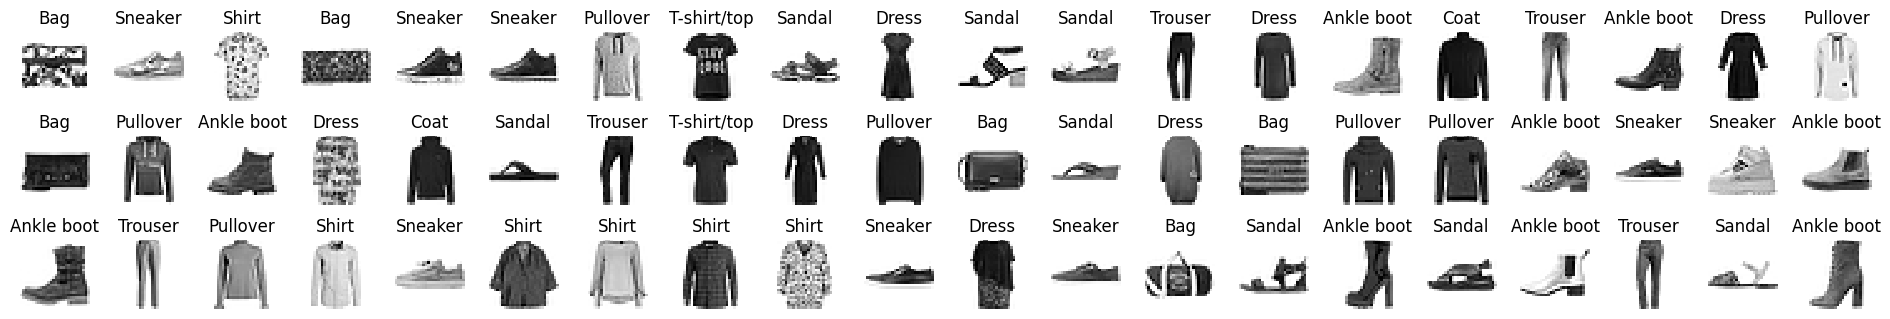

In [6]:
# visualizando algunas imágenes

imprimir_imagenes(X_train, y_train, class_names, n_rows=3, n_cols=20)

In [8]:
# Aqui vamos a definir la red usando la forma funcional

# Definimos la capa de entrada al modelo (como vimos arriba, las imágenes de fashionMNIST son 28x28 y en un solo canal):
input = keras.layers.Input(shape=[28, 28])

# Como haremos una red completamente conectada, hay que transoformar la grilla en un array
flatten = keras.layers.Flatten()(input)

# Definiciones de capas internas
hidden1 = keras.layers.Dense(300, activation="relu")(flatten)
hidden2 = keras.layers.Dense(100, activation="relu")(hidden1)

# Salida
output = keras.layers.Dense(10, activation="softmax")(hidden2)

# Definimos el modelo:
model_clase = keras.models.Model(inputs=[input], outputs=[output])

model_clase.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

history_clase = model_clase.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_valid, y_valid))


Epoch 1/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.7289 - accuracy: 0.7606 - val_loss: 0.5259 - val_accuracy: 0.8166
Epoch 2/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.4933 - accuracy: 0.8286 - val_loss: 0.4563 - val_accuracy: 0.8450
Epoch 3/20
1563/1563 [==============================] - 7s 5ms/step - loss: 0.4459 - accuracy: 0.8454 - val_loss: 0.4557 - val_accuracy: 0.8331
Epoch 4/20
1563/1563 [==============================] - 7s 5ms/step - loss: 0.4186 - accuracy: 0.8529 - val_loss: 0.4211 - val_accuracy: 0.8516
Epoch 5/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.4009 - accuracy: 0.8593 - val_loss: 0.4086 - val_accuracy: 0.8536
Epoch 6/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.3837 - accuracy: 0.8647 - val_loss: 0.3884 - val_accuracy: 0.8634
Epoch 7/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.3712 - accuracy: 0.8698 - val_loss: 0.4298 - val_accuracy:

In [9]:
# 1563/1563 [==============================] - 8s 5ms/step - loss: 0.2723 - accuracy: 0.9026 - val_loss: 0.3152 - val_accuracy: 0.8870


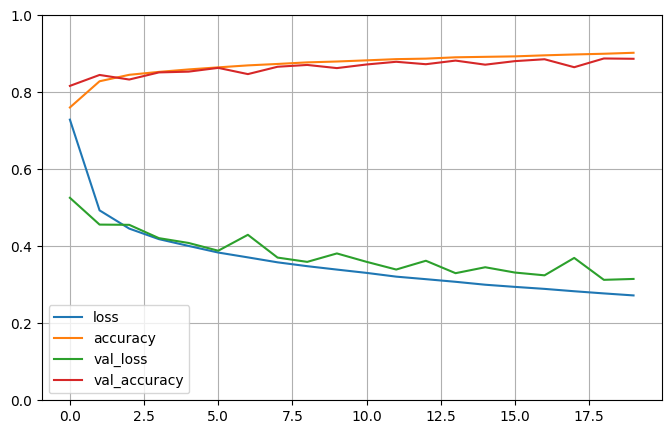

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
313/313 [================

[0.34573259949684143, 0.8776000142097473]

In [17]:
# imprimir el histórico del entrenamiento
imprimir_history(history_clase)
# recordando la arquitectura del modelo que vimos en clase
model_clase.summary()
# evaluando el modelo
model_clase.evaluate(X_test, y_test)

Exactitud en el conjunto de prueba: 0.8776

Veamos cuantos elementos mal clasificados hay:

In [23]:
y_predict_clase = np.argmax(model_clase.predict(X_test), axis=1)
y_predict_clase.round(2)
errores = (y_predict_clase - y_test != 0)

# Cuántos hay
print('Hay {} errores en el conjunto de prueba'.format(np.sum(errores)))

313/313 [==============================] - 1s 2ms/step
Hay 1224 errores en el conjunto de prueba


Hay 1224 errores en el conjunto de prueba, consistente con exactitud 0.88


---
### Después de revisitar el modelo que vimos en clase, empecemos a probar los cambios que nos pide la consigna
---

### Cambiar la regularización

In [19]:
# Por defecto, si no se lo decimos, Keras no usa regularización.
# Aquí vamos a definir la primer capa oculta con una regularización L2

# Reiniciamos la sesión de Keras y fijamos nuevamente la semilla
init()

# Necesitamos definir una capa especial, que es el punto de entrada al modelo:
input = keras.layers.Input(shape=[28, 28])

# y luego instanciar cada capa, y aplicarla como una función a la salida de la capa anterior
flatten = keras.layers.Flatten()(input)

# Definiciones de capas internas
# Experimento regularizando una sola capa (con parámetro de regularización 0.01)
hidden1 = keras.layers.Dense(300, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01))(flatten)
hidden2 = keras.layers.Dense(100, activation="relu")(hidden1)

# salida
output = keras.layers.Dense(10, activation="softmax")(hidden2)

#Una vez que hemos llegado a las salidas, podemos definir el modelo:
model_regu = keras.models.Model(inputs=[input], outputs=[output])

model_regu.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

history_regu = model_regu.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_valid, y_valid))

# Tiempo de corrida: 2m 9s
# Epoch 20/20
# 1563/1563 [==============================] - 7s 4ms/step - loss: 0.4308 - accuracy: 0.8698 - val_loss: 0.5292 - val_accuracy: 0.8195

Epoch 1/20
1563/1563 [==============================] - 12s 8ms/step - loss: 4.0093 - accuracy: 0.7532 - val_loss: 2.9430 - val_accuracy: 0.8072
Epoch 2/20
1563/1563 [==============================] - 8s 5ms/step - loss: 2.2946 - accuracy: 0.8237 - val_loss: 1.7834 - val_accuracy: 0.8336
Epoch 3/20
1563/1563 [==============================] - 9s 5ms/step - loss: 1.4557 - accuracy: 0.8387 - val_loss: 1.1860 - val_accuracy: 0.8400
Epoch 4/20
1563/1563 [==============================] - 8s 5ms/step - loss: 1.0069 - accuracy: 0.8440 - val_loss: 0.8772 - val_accuracy: 0.8384
Epoch 5/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7658 - accuracy: 0.8469 - val_loss: 0.7250 - val_accuracy: 0.8319
Epoch 6/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.6329 - accuracy: 0.8507 - val_loss: 0.6317 - val_accuracy: 0.8296
Epoch 7/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.5581 - accuracy: 0.8542 - val_loss: 0.5385 - val_accuracy

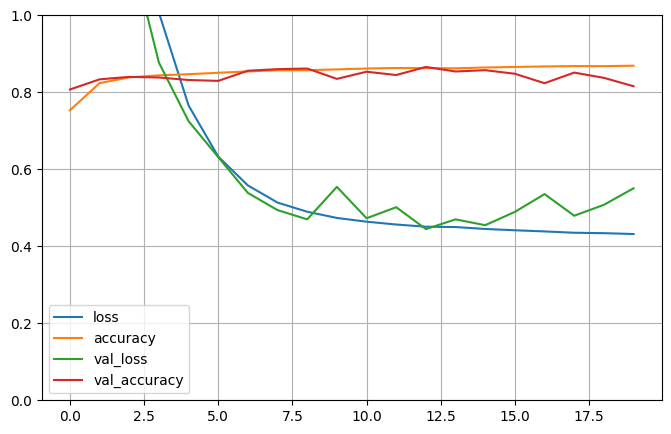

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
313/313 [================

[0.5886868834495544, 0.8044000267982483]

In [20]:
imprimir_history(history_regu)
# estamos usando siempre la misma arquitectura
model_regu.summary()
model_regu.evaluate(X_test, y_test)

In [22]:
y_predict_regu = np.argmax(model_regu.predict(X_test), axis=1)
y_predict_regu.round(2)
errores = (y_predict_regu - y_test != 0)

# Cuántos hay
print('Hay {} errores en el conjunto de prueba'.format(np.sum(errores)))

313/313 [==============================] - 1s 2ms/step
Hay 1956 errores en el conjunto de prueba


Aquí la exactitud en testeo cayó a 0.80 (comparar con 0.88 sin regularización) y de hecho el número de errores aumentó. Para evitar el sobreajuste (disminuir la varianza), terminamos con un sesgo significativo.
¿Qué habría que hacer para intentar mejorar el resultado?

### Cambiar la inicialización

In [24]:
# La inicialización por defecto en Keras para redes completamente conectadas es Glorot
# Aqui cambiaremos para he_normal
init()

input = keras.layers.Input(shape=[28, 28])

flatten = keras.layers.Flatten()(input)

# Definiciones de capas internas
hidden1 = keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal")(flatten)
hidden2 = keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal")(hidden1)

# salida
output = keras.layers.Dense(10, activation="softmax")(hidden2)

#Una vez que hemos llegado a las salidas, podemos definir el modelo:
model_ini = keras.models.Model(inputs=[input], outputs=[output])

model_ini.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

history_ini= model_ini.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_valid, y_valid))


Epoch 1/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7242 - accuracy: 0.7614 - val_loss: 0.5460 - val_accuracy: 0.8142
Epoch 2/20
1563/1563 [==============================] - 7s 5ms/step - loss: 0.4902 - accuracy: 0.8294 - val_loss: 0.4673 - val_accuracy: 0.8318
Epoch 3/20
1563/1563 [==============================] - 9s 5ms/step - loss: 0.4423 - accuracy: 0.8449 - val_loss: 0.4243 - val_accuracy: 0.8539
Epoch 4/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.4153 - accuracy: 0.8531 - val_loss: 0.4200 - val_accuracy: 0.8538
Epoch 5/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.3957 - accuracy: 0.8604 - val_loss: 0.4165 - val_accuracy: 0.8553
Epoch 6/20
1563/1563 [==============================] - 9s 5ms/step - loss: 0.3804 - accuracy: 0.8657 - val_loss: 0.4059 - val_accuracy: 0.8529
Epoch 7/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.3670 - accuracy: 0.8698 - val_loss: 0.3821 - val_accuracy:

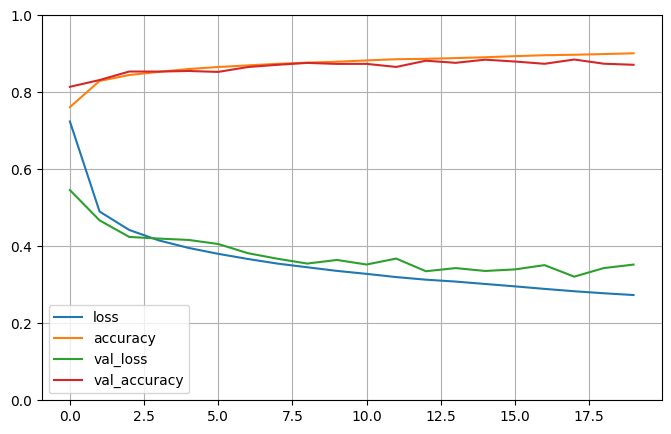

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
313/313 [================

[0.3858901858329773, 0.8578000068664551]

In [25]:
imprimir_history(history_ini)
# estamos usando siempre la misma arquitectura
model_ini.summary()
model_ini.evaluate(X_test, y_test)

In [27]:
y_predict_ini = np.argmax(model_ini.predict(X_test), axis=1)
y_predict_ini.round(2)
errores = (y_predict_ini - y_test != 0)

# Cuántos hay
print('Hay {} errores en el conjunto de prueba'.format(np.sum(errores)))

# Hay 1929 errores en el conjunto de validación

313/313 [==============================] - 2s 6ms/step
Hay 1422 errores en el conjunto de prueba


Aqui hubo un cambio pequeño de la exactitud en relación al modelo que vimos en clase, con la inicialización de Glorot. De 0.88 con Glorot pasamos a 0.86 con He_normal. Vemos que tenemos más errores en este último caso, como era de esperar.

### Añadir un callback para implementar una programación de la tasa de aprendizaje


In [39]:
# Vamos a implementar una programación de la tasa de aprendizaje

init()

input = keras.layers.Input(shape=[28, 28])

flatten = keras.layers.Flatten()(input)

hidden1 = keras.layers.Dense(300, activation="relu")(flatten)
hidden2 = keras.layers.Dense(100, activation="relu")(hidden1)

output = keras.layers.Dense(10, activation="softmax")(hidden2)

#Una vez que hemos llegado a las salidas, podemos definir el modelo:
model_lr = keras.models.Model(inputs=[input], outputs=[output])

# aqui definimos la programación de la tasa de aprendizaje, con learning_rate=0.001 y momentum=0.9
model_lr.compile(loss="sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
              metrics=["accuracy"])

history_lr= model_lr.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_valid, y_valid))


Epoch 1/20
1563/1563 [==============================] - 9s 5ms/step - loss: 0.7348 - accuracy: 0.7609 - val_loss: 0.5420 - val_accuracy: 0.8135
Epoch 2/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.4911 - accuracy: 0.8303 - val_loss: 0.4710 - val_accuracy: 0.8348
Epoch 3/20
1563/1563 [==============================] - 10s 6ms/step - loss: 0.4471 - accuracy: 0.8453 - val_loss: 0.4285 - val_accuracy: 0.8493
Epoch 4/20
1563/1563 [==============================] - 14s 9ms/step - loss: 0.4205 - accuracy: 0.8534 - val_loss: 0.4167 - val_accuracy: 0.8553
Epoch 5/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.4005 - accuracy: 0.8612 - val_loss: 0.4122 - val_accuracy: 0.8558
Epoch 6/20
1563/1563 [==============================] - 9s 5ms/step - loss: 0.3855 - accuracy: 0.8655 - val_loss: 0.4134 - val_accuracy: 0.8560
Epoch 7/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.3708 - accuracy: 0.8712 - val_loss: 0.4150 - val_accurac

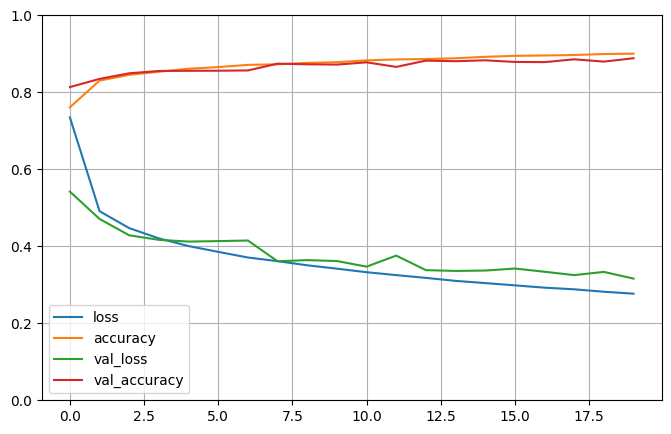

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
313/313 [================

[0.3414129316806793, 0.8795999884605408]

In [40]:
imprimir_history(history_lr)
# estamos usando siempre la misma arquitectura
model_lr.summary()
model_lr.evaluate(X_test, y_test)

In [41]:
y_predict_lr = np.argmax(model_lr.predict(X_test), axis=1)
y_predict_lr.round(2)
errores = (y_predict_lr - y_test != 0)

# Cuántos hay
print('Hay {} errores en el conjunto de prueba'.format(np.sum(errores)))

313/313 [==============================] - 1s 3ms/step
Hay 1204 errores en el conjunto de prueba


Aquí obtuvimos un resultado un poquito mejor que con la configuración estándar, obteniendo una exactitud en el conjunto de prueba de 0.8796 (comparar con 0.8776). Y de hecho el número de clasificaciones equivocadas cayó de
1224 a 1205.

### Cambiar el optimizador

Hasta aquí veníamos usando el optimizador por descenso del gradiente (SGD).
Ahora vamos a cambiar el optimizador para Adam, que viene de _Adaptive Moment Estimation_, o sea, Estimación Adaptativa del Momento. Ese optimizador actualiza los pesos durante el entrenamiento. La idea básica detrás de la optimización de Adam es ajustar la tasa de aprendizaje de manera adaptativa para cada parámetro en el modelo en función del historial de gradientes calculados para ese parámetro.

In [35]:
init()

input = keras.layers.Input(shape=[28, 28])

flatten = keras.layers.Flatten()(input)

hidden1 = keras.layers.Dense(300, activation="relu")(flatten)
hidden2 = keras.layers.Dense(100, activation="relu")(hidden1)

output = keras.layers.Dense(10, activation="softmax")(hidden2)

model_opt = keras.models.Model(inputs=[input], outputs=[output])

# aqui definimos la programación de la tasa de aprendizaje, con learning_rate=0.001 y momentum=0.9
model_opt.compile(loss="sparse_categorical_crossentropy",
              optimizer = "Adam",
              metrics=["accuracy"])

history_opt= model_opt.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_valid, y_valid))




Epoch 1/20
1563/1563 [==============================] - 14s 9ms/step - loss: 0.4958 - accuracy: 0.8227 - val_loss: 0.3985 - val_accuracy: 0.8572
Epoch 2/20
1563/1563 [==============================] - 14s 9ms/step - loss: 0.3692 - accuracy: 0.8644 - val_loss: 0.4288 - val_accuracy: 0.8278
Epoch 3/20
1563/1563 [==============================] - 15s 10ms/step - loss: 0.3306 - accuracy: 0.8784 - val_loss: 0.3234 - val_accuracy: 0.8820
Epoch 4/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.3070 - accuracy: 0.8852 - val_loss: 0.3475 - val_accuracy: 0.8768
Epoch 5/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2887 - accuracy: 0.8918 - val_loss: 0.3333 - val_accuracy: 0.8807
Epoch 6/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2751 - accuracy: 0.8960 - val_loss: 0.3197 - val_accuracy: 0.8842
Epoch 7/20
1563/1563 [==============================] - 10s 6ms/step - loss: 0.2611 - accuracy: 0.9006 - val_loss: 0.3289 - val_a

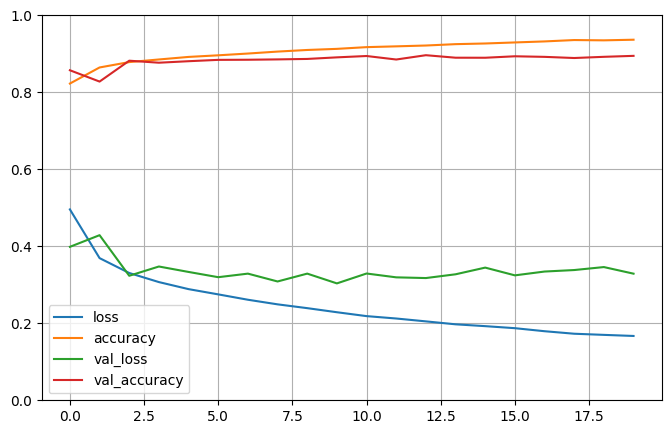

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
313/313 [================

[0.36333566904067993, 0.8881999850273132]

In [36]:
imprimir_history(history_opt)
# estamos usando siempre la misma arquitectura
model_opt.summary()
model_opt.evaluate(X_test, y_test)

In [37]:
y_predict_opt = np.argmax(model_opt.predict(X_test), axis=1)
y_predict_opt.round(2)
errores = (y_predict_opt - y_test != 0)

# Cuántos hay
print('Hay {} errores en el conjunto de prueba'.format(np.sum(errores)))

313/313 [==============================] - 1s 2ms/step
Hay 1118 errores en el conjunto de prueba


Aquí obtuvimos un resultado un poco mejor que con la configuración con SGD, obteniendo una exactitud en el conjunto de prueba de 0.888 (comparar con 0.877). Y de hecho el número de clasificaciones equivocadas cayó de
1224 a 1118.

## Ejercicio 2 - Combinación con otros métodos - PCA

Aquí mantendremos nuevamente una red similar a la que vimos en clase y useremos el conjunto MNIST, pero la idea es ver el impacto de la reducción de dimensionalidad sobre los resultados.

* Usar PCA (de `sklearn`) para reducir la dimensionalidad del conjunto de MNIST. Decidir una cantidad de componentes razonable, que guarde al menos el 90% de la varianza de los datos (recuérdense del notebook onde hemos hecho PCA con MNIST e incluso hemos visualizado el efecto de mantener N componentes).

* Crear una red con una arquitectura similar a la que vimos en clase.

* Usar la red para clasificar MNIST en su versión reducida.

* Comparar la performance de la red que vimos en clase, entrenada sobre todo el conjunto, y la red entrenada sobre el conjunto reducido. Piensen antes: ¿tienen la misma cantidad de parámetros ambas redes? ¿es justo comparar modelos con número de parámetros muy diferentes?

Primero reproducimos lo que hicimos en clase con MNIST. Aquí, vamos a separar los datos en entrenamiento, validación y testeo y no utilizaremos la codificación one-hot.

In [2]:
# cargamos el conjunto de datos
(X_train_full, t_train_full), (X_test, t_test) = keras.datasets.mnist.load_data()

# recordemos el tamaño del dataset
X_train_full.shape, X_test.shape, t_train_full.shape, t_test.shape

11490434/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [3]:
# separemos el conjunto de entrenamiento completo en entrenamiento + validación y normalicemos los datos

X_valid, X_train = X_train_full[:10000] / 255., X_train_full[10000:] / 255.
t_valid, t_train = t_train_full[:10000], t_train_full[10000:]
X_test = X_test / 255.

X_train.shape, X_valid.shape, t_train.shape, t_valid.shape

((50000, 28, 28), (10000, 28, 28), (50000,), (10000,))

Armamos la misma red que en clase, usando la forma secuencial, y compilamos



In [10]:
# Reiniciamos la sesión de Keras y fijamos la semilla
init()

modelo_MNIST_full = keras.models.Sequential()

# Input layer
modelo_MNIST_full.add(keras.layers.Flatten(input_shape=(28,28)))

# Dos capas ocultas con 32 neuronas cada una
modelo_MNIST_full.add(keras.layers.Dense(32, activation='relu'))
modelo_MNIST_full.add(keras.layers.Dense(32, activation='relu'))

# Capa de salida. Como es una clasificación multi-clase, usamo K (acá 10) unidades.
modelo_MNIST_full.add(keras.layers.Dense(10, activation='softmax'))

# Aqui usamos sparse_categorical_crossentropy porque no hicimos la codificación one-hot
modelo_MNIST_full.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
# recordando cuantos parámetros libres tiene

modelo_MNIST_full.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 32)                25120     
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 26506 (103.54 KB)
Trainable params: 26506 (103.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# Definimos un early stopping y entrenamos

early = keras.callbacks.EarlyStopping(patience=15, monitor='val_loss',
                                      restore_best_weights=True)

ajuste_full = modelo_MNIST_full.fit(epochs=100, x=X_train, y=t_train, validation_data=(X_valid, t_valid), callbacks=[early,])


Epoch 1/100
1563/1563 [==============================] - 6s 3ms/step - loss: 0.3815 - accuracy: 0.8904 - val_loss: 0.2490 - val_accuracy: 0.9268
Epoch 2/100
1563/1563 [==============================] - 6s 4ms/step - loss: 0.1987 - accuracy: 0.9425 - val_loss: 0.1866 - val_accuracy: 0.9475
Epoch 3/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1554 - accuracy: 0.9547 - val_loss: 0.1646 - val_accuracy: 0.9507
Epoch 4/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1314 - accuracy: 0.9616 - val_loss: 0.1458 - val_accuracy: 0.9575
Epoch 5/100
1563/1563 [==============================] - 6s 4ms/step - loss: 0.1149 - accuracy: 0.9670 - val_loss: 0.1408 - val_accuracy: 0.9611
Epoch 6/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1042 - accuracy: 0.9699 - val_loss: 0.1362 - val_accuracy: 0.9608
Epoch 7/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0959 - accuracy: 0.9731 - val_loss: 0.1320 - val_ac

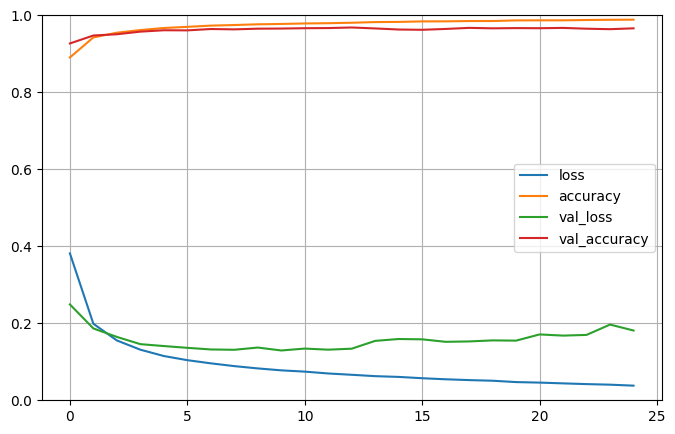

313/313 [==============================] - 1s 4ms/step - loss: 0.1246 - accuracy: 0.9669


[0.1245974600315094, 0.9668999910354614]

In [13]:
# imprimir el histórico del entrenamiento
imprimir_history(ajuste_full)
# evaluando el modelo
modelo_MNIST_full.evaluate(X_test, t_test)

Exactitud en el conjunto de prueba: 0.967

Veamos cuantos elementos mal clasificados hay:

In [14]:
t_predict = np.argmax(modelo_MNIST_full.predict(X_test), axis=1)
t_predict.round(2)
errores = (t_predict - t_test != 0)

# Cuántos hay
print('Hay {} errores en el conjunto de prueba'.format(np.sum(errores)))

313/313 [==============================] - 1s 3ms/step
Hay 331 errores en el conjunto de prueba


Hay 313 errores en el conjunto de prueba.


### Usar PCA para reducir la dimensionalidad del conjunto de MNIST.

In [41]:
from sklearn.decomposition import PCA
from numpy import ndarray

pca = PCA()  # fiteo sin reducir la dimensionalidad

# para hacer la PCA tenemos que dar un array, no una matrix (imagen), por eso hay que aplanar los datos de imagen 28 x 28
X_train_p = X_train.reshape((X_train.shape[0], 784))

# Encuentra los componentes principales
X_train_pca = pca.fit_transform(X_train_p)

# Recordemos la forma de salida. Por ahora se mantienen todos los componentes, pero están transformados en X_train_pca
print(X_train.shape, X_train_p.shape, X_train_pca.shape)

(50000, 28, 28) (50000, 784) (50000, 784)


### Decidir una cantidad de componentes razonable, que guarde al menos el 90% de la varianza de los datos.  

Recuerden que se pueden guiar cuantitativamente con el `pca.explained_variance_ratio_` que vimos antes en clase.

In [42]:
# Definir qué fracción de la varianza se quiere mantener
var_frac = 0.9

# Calcular la suma cumulativa y hacer su gráfica
cumsum = np.cumsum(pca.explained_variance_ratio_)
# eso nos dice cuanta información es retenida si paramos en cada dimensión

# En qué momento la suma cumulativa llega a var_frac * 100 %?
d = np.argmax(cumsum >= var_frac) + 1
print('Con {} componentes, preservamos el {} de la varianza.'.format(d, var_frac))

Con 88 componentes, preservamos el 0.9 de la varianza.


Vean la brutal reducción de dimensionalidad, pasando de 784 componentes a "solamente" 88.

Entonces vamos a transformar todos los datos y a quedarnos con solamente las 88 primeras componentes

In [49]:
# primero transformemos los conjuntos de validación y prueba
# acuerdense que vamos a usar la misma transformación PCA ajustada de los datos de entrenamiento en validación y prueba
X_valid_p = X_valid.reshape((X_valid.shape[0], 784))
X_valid_pca = pca.transform(X_valid_p)

X_test_p = X_test.reshape((X_test.shape[0], 784))
X_test_pca = pca.transform(X_test_p)

# Nos quedamos con solo las primeras 88 componentes
X_train_pca = X_train_pca[:,:88]
X_valid_pca = X_valid_pca[:,:88]
X_test_pca = X_test_pca[:,:88]

# chequeando que todo esté bien con las dimensiones

print(X_train_pca.shape, X_valid_pca.shape, X_test_pca.shape)

(50000, 88) (10000, 88) (10000, 88)


### Crear una red con una arquitectura similar a la que vimos en clase

Fíjense que las entradas ahora ya están aplanadas: las imágenes no vienen en conjuntos de 28 x 28, ya que fueron transformadas y truncadas en las 88 primeras componentes.
Entonces, mantenemos la misma estructura de las capas ocultas, pero la capa de entrada recibirá 88 valores.

In [50]:
modelo_MNIST_pca = keras.models.Sequential()

# Capa de entrada. Ahora no hay que hacer flatten y tenemos 88 valores como entrada
modelo_MNIST_pca.add(keras.layers.InputLayer(input_shape=(88,)))

# Dos capas ocultas con 32 neuronas cada una
modelo_MNIST_pca.add(keras.layers.Dense(32, activation='relu'))
modelo_MNIST_pca.add(keras.layers.Dense(32, activation='relu'))

# Capa de salida. Como es una clasificación multi-clase, usamo K (acá 10) unidades.
modelo_MNIST_pca.add(keras.layers.Dense(10, activation='softmax'))

# Aqui usamos sparse_categorical_crossentropy porque no hicimos la codificación one-hot
modelo_MNIST_pca.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [51]:
# cuántos parámetros libres creen que tendrá esa red?

modelo_MNIST_pca.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                2848      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 10)                330       
                                                                 
Total params: 4234 (16.54 KB)
Trainable params: 4234 (16.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Comparen con los 26506 parámetros de la red con los datos completos de MNIST (sin hacer reducción dimensional via PCA)

### Usar la red para clasificar MNIST en su versión reducida.



In [52]:
# Definimos un early stopping y entrenamos

early = keras.callbacks.EarlyStopping(patience=15, monitor='val_loss',
                                      restore_best_weights=True)

ajuste_pca = modelo_MNIST_pca.fit(epochs=100, x=X_train_pca, y=t_train, validation_data=(X_valid_pca, t_valid), callbacks=[early,])


Epoch 1/100
1563/1563 [==============================] - 8s 4ms/step - loss: 0.5104 - accuracy: 0.8506 - val_loss: 0.2392 - val_accuracy: 0.9312
Epoch 2/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.2046 - accuracy: 0.9396 - val_loss: 0.1829 - val_accuracy: 0.9458
Epoch 3/100
1563/1563 [==============================] - 6s 4ms/step - loss: 0.1603 - accuracy: 0.9520 - val_loss: 0.1622 - val_accuracy: 0.9516
Epoch 4/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1354 - accuracy: 0.9595 - val_loss: 0.1427 - val_accuracy: 0.9597
Epoch 5/100
1563/1563 [==============================] - 6s 4ms/step - loss: 0.1188 - accuracy: 0.9643 - val_loss: 0.1338 - val_accuracy: 0.9627
Epoch 6/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1082 - accuracy: 0.9670 - val_loss: 0.1277 - val_accuracy: 0.9618
Epoch 7/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0991 - accuracy: 0.9700 - val_loss: 0.1294 - val_ac

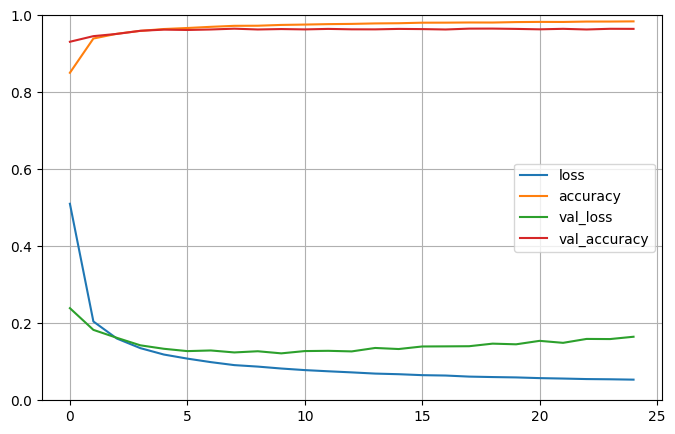

In [56]:
# imprimir el histórico del entrenamiento
imprimir_history(ajuste_pca)

### Comparar la performance de la red que vimos en clase, entrenada sobre todo el conjunto, y la red entrenada sobre el conjunto reducido.

In [55]:
# evaluando el modelo
modelo_MNIST_pca.evaluate(X_test_pca, t_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.1156 - accuracy: 0.9670


[0.11562053114175797, 0.9670000076293945]

En este caso, el resultado de la exactitud en el conjunto de prueba con los dados con reducción dimensionalidad, 0.9670, fue incluso un cachito mejor que usando los datos completos, 0.9669. Claro que esas diferencias son ínfimas y podría haber flucutaciones para cualquiera de los dos lados, sea por pequeños cambios en los datos o por todos los factorereas aleatorios que entran en los cálculos.

El punto importante es que la performance se mantuvo más o menos igual, aunque hayamos hecho una reducción brutal de la dimensionalidad. Al final quedarse con las componentes responsables por 90% de la varianza en los datos fue suficiente para manener la calidad de la clasificiación! Claramente ganamos en velocidad de entrenamiento porque tenemos mucho menos parámetros y los datos tienen un volumen mucho menor.

Como vimos, existen muchas métricas para evaluar la performance de una tarea de clasificiación. Como quedarán las otras en este caso?

Veamos cuantos elementos mal clasificados hay:

In [57]:
t_predict_pca = np.argmax(modelo_MNIST_pca.predict(X_test_pca), axis=1)
t_predict_pca.round(2)
errores = (t_predict_pca - t_test != 0)

# Cuántos hay
print('Hay {} errores en el conjunto de prueba con los datos transformados por PCA'.format(np.sum(errores)))

313/313 [==============================] - 1s 2ms/step
Hay 330 errores en el conjunto de prueba con los datos transformados por PCA


Es un número muy semejante, pero un poquito mayor que lo que había sido obtenido con los datos sin reducción dimensional (313 errores en el conjunto de prueba).
